In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import pyro
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.tools.utils import clean_up_adata

2024-10-24 16:26:32.651426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from spaceoracle.tools.data import LigRecDataset

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

import scanpy as sc

In [6]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [7]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [208]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Il2ra',
)

In [255]:
groups = [1]*len(estimator.regulators) + [2]*len(estimator.ligands)
groups = np.array(groups)

# coefs = np.array(betas[1:])
coefs = betas
betas.shape, coefs.shape, groups.shape

((112,), (112,), (112,))

In [270]:
np.percentile(abs(betas), 5)

0.0008525556918445685

In [271]:
np.percentile(abs(betas), 95)

0.09524893353964445

(array([ 2.,  1.,  3.,  6.,  5.,  6.,  1., 47.,  0.,  7.,  6.,  2.,  4.,
         1.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.14535238, -0.12628802, -0.10722367, -0.08815931, -0.06909495,
        -0.0500306 , -0.03096624, -0.01190188,  0.00716248,  0.02622683,
         0.04529119,  0.06435555,  0.0834199 ,  0.10248426,  0.12154862,
         0.14061298,  0.15967733,  0.17874169,  0.19780605,  0.21687041,
         0.23593476]),
 <BarContainer object of 20 artists>)

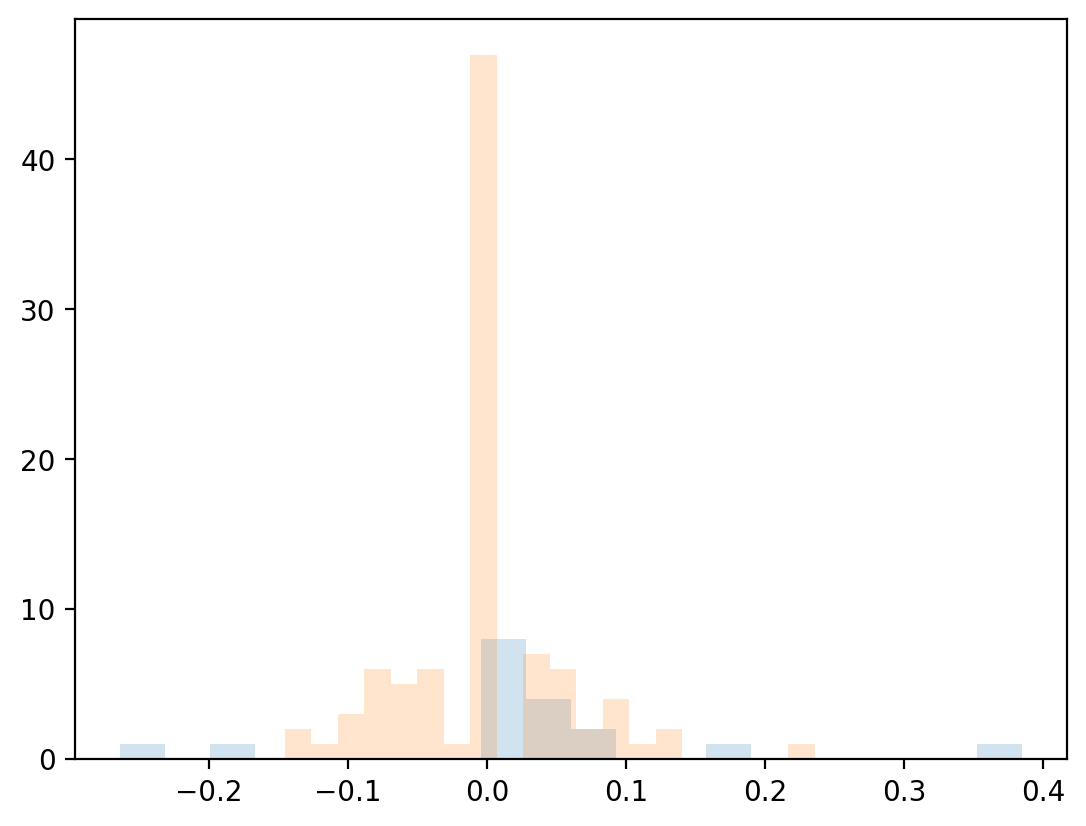

In [273]:
plt.hist(betas[:len(estimator.regulators)], bins=20, alpha=0.2)
plt.hist(betas[-len(estimator.ligands):], bins=20, alpha=0.2)

In [274]:
%%time

estimator.fit(num_epochs=1, threshold_lambda=3e3, learning_rate=1e-3)

CPU times: user 22.4 s, sys: 2.02 s, total: 24.4 s
Wall time: 24.9 s


array([ 0.38465992, -0.17619907,  0.18996161,  0.        ,  0.        ,
        0.        ,  0.04557799,  0.        ,  0.03225569,  0.05309025,
        0.        ,  0.04066712, -0.26377443,  0.        ,  0.07086469,
        0.        ,  0.06658998,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03206062,  0.        , -0.04452198,  0.        ,
        0.        ,  0.0834203 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.06603594,  0.        ,
        0.0467368 , -0.1185923 ,  0.10235354,  0.        ,  0.09507862,
       -0.08375449, -0.04592945, -0.03372569,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.03105069,  0.        ,  0.08987593,  0.        ,  0.        ,
        0.        ,  0.        ,  0.06584274, -0.05769838, -0.08660113,
        0.03456714,  0.        , -0.07712492, -0.09202685,  0.13673174,
       -0.04177435, -0.07042824,  0.05691029,  0.        ,  0.  

In [183]:
estimator.Xn[:, :len(estimator.regulators)].shape

(11567, 18)

In [184]:
idx = np.arange(len(estimator.regulators))
estimator.Xn[:, idx].shape

(11567, 18)

In [185]:
np.arange(len(idx), len(idx) + len(estimator.ligands))

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111])

In [186]:
estimator.Xn.shape

(11567, 112)

In [187]:
estimator.modulators

['Bcl11a',
 'Egr1',
 'Erg',
 'Foxj3',
 'Gtf3c2',
 'Hdac2',
 'Hivep1',
 'Klf7',
 'Nfia',
 'Nfib',
 'Nr3c1',
 'Pax5',
 'Runx2',
 'Rxra',
 'Smad1',
 'Taf1',
 'Zbtb6',
 'Zfp523',
 'Bmp2$Bmpr1a',
 'Bmp2$Acvr2a',
 'Bmp2$Bmpr2',
 'Gdf10$Acvr2a',
 'Vegfa$Flt1',
 'Vegfa$Kdr',
 'Pgf$Flt1',
 'Igf1$Itgb3',
 'Igf1$Itga6',
 'Ccl5$Ccr1',
 'Ccl8$Ccr1',
 'Ccl9$Ccr1',
 'Ccl6$Ccr1',
 'Ccl7$Ccr1',
 'Ccl8$Ccr2',
 'Ccl6$Ccr2',
 'Ccl7$Ccr2',
 'Ccl2$Ccr2',
 'Ccl12$Ccr2',
 'Ccl4$Ccr5',
 'Ccl5$Ccr5',
 'Ccl8$Ccr5',
 'Ccl20$Ccr6',
 'Ccl25$Ackr4',
 'Ccl8$Ackr4',
 'Ccl2$Ackr1',
 'Ccl5$Ackr1',
 'Ccl7$Ackr1',
 'Ccl8$Ackr1',
 'Ccl11$Ackr1',
 'Ccl17$Ackr1',
 'Cxcl1$Cxcr2',
 'Cxcl12$Cxcr4',
 'Cxcl13$Cxcr5',
 'Cxcl1$Ackr1',
 'Cxcl9$Ackr1',
 'Cxcl10$Ackr1',
 'Cxcl13$Ackr1',
 'Il2$Il2rb',
 'Il2$Il2rg',
 'Il4$Il4ra',
 'Il4$Il2rg',
 'Il7$Il7r',
 'Il7$Il2rg',
 'Il15$Il15ra',
 'Il15$Il2rb',
 'Il15$Il2rg',
 'Il21$Il21r',
 'Il21$Il2rg',
 'Il4$Il13ra1',
 'Il4$Il13ra2',
 'Il12b$Il12rb1',
 'Ebi3$Il27ra',
 'Ebi3$Il6st',
 'Clcf1$Il6s

In [188]:
betas_df = estimator.get_betas()
betas_df

,beta0,beta_Bcl11a,beta_Egr1,beta_Erg,beta_Foxj3,beta_Gtf3c2,beta_Hdac2,beta_Hivep1,beta_Klf7,beta_Nfia,...,beta_Gzma$F2r,beta_Gzma$F2rl2,beta_Gzma$Pard3,beta_Sema3a$Plxna3,beta_Sema3d$Plxna3,beta_Sema3d$Nrp2,beta_Sema3f$Nrp2,beta_Sema3f$Plxna3,beta_Gas6$Mertk,beta_Gas6$Tyro3
AAAAAACGGTAGAT,0.432400,-0.103605,0.108130,0.000000,0.012043,0.0,0.026131,0.014371,0.014121,0.023630,...,-0.011316,-0.026723,0.0,-0.042477,0.029831,0.0,0.000000,0.0,0.000000,0.009586
AAAAAATCCGGCGA,0.575179,-0.082752,0.004251,0.021914,0.028191,0.0,0.016374,0.017397,-0.020066,0.000000,...,-0.022851,0.000000,0.0,-0.082605,0.000000,0.0,0.000000,0.0,0.007089,0.053399
AAAAACCGTCAGAC,0.403244,-0.102606,0.109774,0.000000,0.011915,0.0,0.025964,0.014172,0.013764,0.023638,...,-0.011434,-0.026246,0.0,-0.042297,0.029956,0.0,0.000000,0.0,0.000000,0.009515
AAAAACGCTCCGAC,0.413824,-0.102882,0.109218,0.000000,0.011900,0.0,0.026060,0.014184,0.013905,0.023703,...,-0.011415,-0.026406,0.0,-0.042524,0.029969,0.0,0.000000,0.0,0.000000,0.009560
AAAAAGCACGTGTT,0.407464,-0.102615,0.109357,0.000000,0.011923,0.0,0.025958,0.014178,0.013828,0.023670,...,-0.011421,-0.026301,0.0,-0.042360,0.029941,0.0,0.000000,0.0,0.000000,0.009529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,0.559045,-0.083397,0.004125,0.022188,0.028526,0.0,0.016471,0.017295,-0.019941,0.000000,...,-0.023041,0.000000,0.0,-0.082834,0.000000,0.0,0.000000,0.0,0.006889,0.054951
TTTTTTGGGCTGGT,0.728716,-0.111254,0.033564,0.000000,0.000000,0.0,0.043128,0.000000,-0.017544,0.000000,...,-0.032625,-0.022159,0.0,0.000000,0.000000,0.0,-0.019294,0.0,0.007222,0.010317
TTTTTTGTACCCAC,0.678275,-0.116585,0.032860,0.000000,0.000000,0.0,0.042671,0.000000,-0.017928,0.000000,...,-0.031144,-0.021804,0.0,0.000000,0.000000,0.0,-0.018912,0.0,0.007048,0.010270
TTTTTTGTACGATT,0.510451,-0.103195,0.104103,0.000000,0.011847,0.0,0.026690,0.014382,0.015034,0.024502,...,-0.011116,-0.027257,0.0,-0.044540,0.029791,0.0,0.000000,0.0,0.000000,0.009892


In [189]:
lr_pairs = [f'beta_{lr}'for lr in list(estimator.lr['pairs'])]
lr_betas = betas_df[lr_pairs]
lr_betas

,beta_Bmp2$Bmpr1a,beta_Bmp2$Acvr2a,beta_Bmp2$Bmpr2,beta_Gdf10$Acvr2a,beta_Vegfa$Flt1,beta_Vegfa$Kdr,beta_Pgf$Flt1,beta_Igf1$Itgb3,beta_Igf1$Itga6,beta_Ccl5$Ccr1,...,beta_Gzma$F2r,beta_Gzma$F2rl2,beta_Gzma$Pard3,beta_Sema3a$Plxna3,beta_Sema3d$Plxna3,beta_Sema3d$Nrp2,beta_Sema3f$Nrp2,beta_Sema3f$Plxna3,beta_Gas6$Mertk,beta_Gas6$Tyro3
AAAAAACGGTAGAT,0.000000,0.000000,0.010979,0.0,-0.021339,0.000000,0.000000,0.036205,0.008849,0.000000,...,-0.011316,-0.026723,0.0,-0.042477,0.029831,0.0,0.000000,0.0,0.000000,0.009586
AAAAAATCCGGCGA,0.110727,0.000000,0.001720,0.0,-0.001168,-0.023534,0.000000,0.000000,0.074210,0.000000,...,-0.022851,0.000000,0.0,-0.082605,0.000000,0.0,0.000000,0.0,0.007089,0.053399
AAAAACCGTCAGAC,0.000000,0.000000,0.011004,0.0,-0.021454,0.000000,0.000000,0.035659,0.008917,0.000000,...,-0.011434,-0.026246,0.0,-0.042297,0.029956,0.0,0.000000,0.0,0.000000,0.009515
AAAAACGCTCCGAC,0.000000,0.000000,0.011011,0.0,-0.021425,0.000000,0.000000,0.035847,0.008895,0.000000,...,-0.011415,-0.026406,0.0,-0.042524,0.029969,0.0,0.000000,0.0,0.000000,0.009560
AAAAAGCACGTGTT,0.000000,0.000000,0.011001,0.0,-0.021445,0.000000,0.000000,0.035734,0.008902,0.000000,...,-0.011421,-0.026301,0.0,-0.042360,0.029941,0.0,0.000000,0.0,0.000000,0.009529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,0.110623,0.000000,0.001758,0.0,-0.001151,-0.023641,0.000000,0.000000,0.070925,0.000000,...,-0.023041,0.000000,0.0,-0.082834,0.000000,0.0,0.000000,0.0,0.006889,0.054951
TTTTTTGGGCTGGT,-0.000786,-0.071747,0.057763,0.0,0.000000,-0.036699,-0.042634,0.013536,0.000000,0.013734,...,-0.032625,-0.022159,0.0,0.000000,0.000000,0.0,-0.019294,0.0,0.007222,0.010317
TTTTTTGTACCCAC,-0.000775,-0.071183,0.056801,0.0,0.000000,-0.036774,-0.043554,0.012903,0.000000,0.013845,...,-0.031144,-0.021804,0.0,0.000000,0.000000,0.0,-0.018912,0.0,0.007048,0.010270
TTTTTTGTACGATT,0.000000,0.000000,0.011010,0.0,-0.020766,0.000000,0.000000,0.037109,0.008722,0.000000,...,-0.011116,-0.027257,0.0,-0.044540,0.029791,0.0,0.000000,0.0,0.000000,0.009892


In [190]:
y = estimator.adata.to_df()[estimator.target_gene]
X = estimator.train_df.drop(estimator.target_gene, axis=1).values

X.shape, y.shape

((11567, 112), (11567,))

In [191]:
groups = [1] * len(estimator.regulators) + [2] * len(estimator.ligands)
groups = np.array(groups).reshape(-1,1)
groups.shape

(112, 1)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

from group_lasso import GroupLasso

np.random.seed(0)
GroupLasso.LOG_LOSSES = True

In [107]:
group_sizes = [np.random.randint(30) for i in range(3)]
active_groups = [np.random.randint(2) for _ in group_sizes]
groups = np.concatenate(
    [size * [i] for i, size in enumerate(group_sizes)]
).reshape(-1, 1)
num_coeffs = sum(group_sizes)
num_datapoints = 10000
noise_std = 20

In [78]:
X = np.random.standard_normal((num_datapoints, num_coeffs))

In [79]:
w = np.concatenate(
    [
        np.random.standard_normal(group_size) * is_active
        for group_size, is_active in zip(group_sizes, active_groups)
    ]
)
w = w.reshape(-1, 1)
true_coefficient_mask = w != 0
intercept = 2

In [80]:
y_true = X @ w + intercept
y = y_true + np.random.randn(*y_true.shape) * noise_std

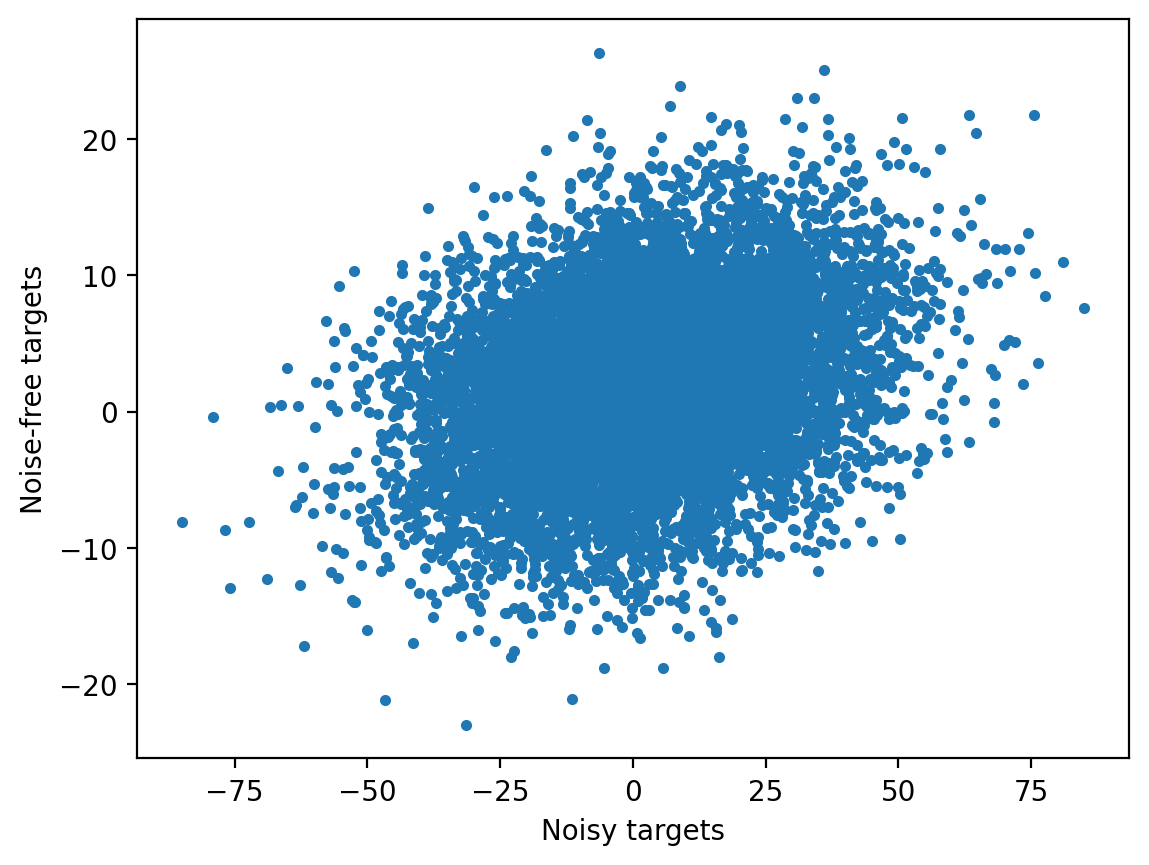

In [81]:
plt.figure()
plt.plot(y, y_true, ".")
plt.xlabel("Noisy targets")
plt.ylabel("Noise-free targets")
# Use noisy y as true because that is what we would have access
# to in a real-life setting.
R2_best = r2_score(y, y_true)

In [120]:
X.shape, y.shape, groups.shape

((11567, 131), (11567,), (131, 1))

In [202]:
gl = GroupLasso(
    groups=groups,
    group_reg=1e-3,
    l1_reg=0,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    # supress_warning=True,
    n_iter=1000,
    tol=1e-3,
)
gl.fit(X, y)

GroupLasso(frobenius_lipschitz=True, group_reg=0.001,
           groups=array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]]),
           l1_reg=0, n_iter=1000, scale_reg='inverse_group_size',
           subsampling_scheme=1, tol=0.001)

In [203]:
# Extract info from estimator
yhat = gl.predict(X)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
R2 = r2_score(y, yhat)

# Print results
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"R^2: {R2}, best possible R^2 = {R2_best}")

Number variables: 112
Number of chosen variables: 112
R^2: 0.028086933945440817, best possible R^2 = 0.09270489318981323


In [204]:
w = np.ones(w_hat.shape)

In [205]:
w_hat[-len(estimator.regulators):].shape

(18, 1)

(0,)

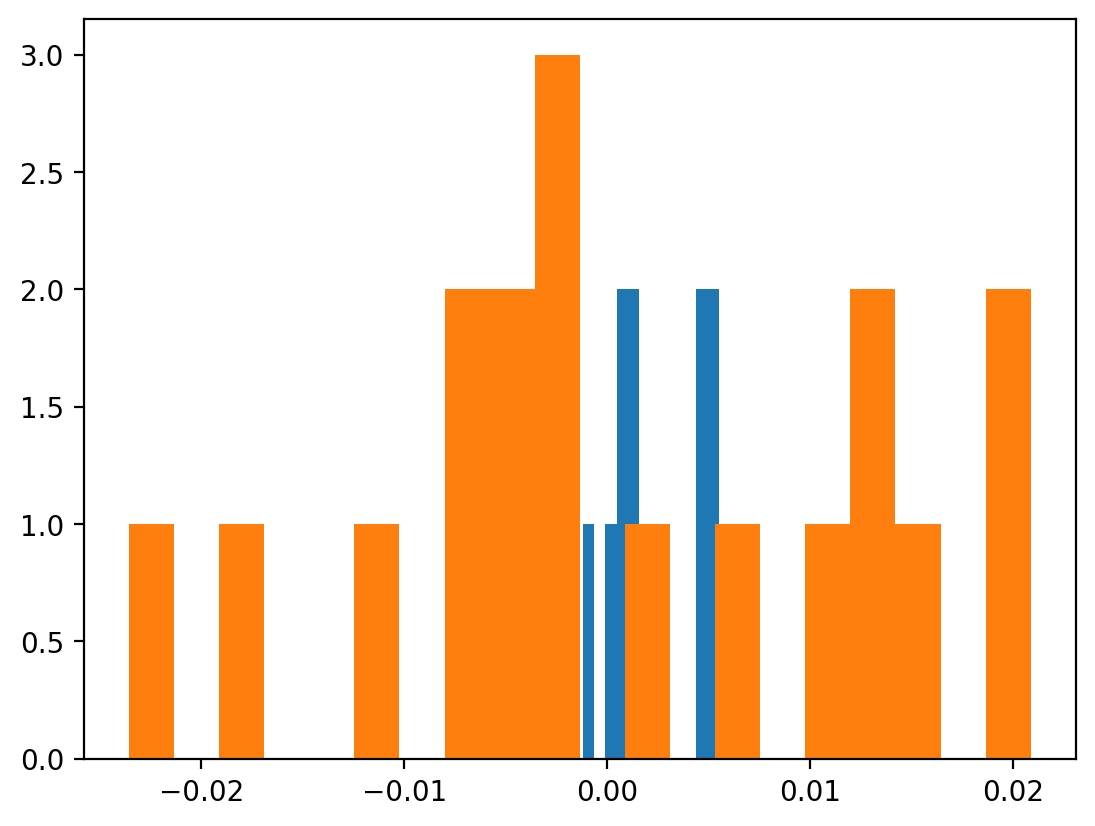

In [206]:
plt.hist(w_hat[:len(estimator.regulators)], bins=20)
plt.hist(w_hat[-len(estimator.regulators):], bins=20)
w_hat[w_hat == 0].shape

X shape: (11567, 112)
True intercept: 2
Estimated intercept: [0.01872638]


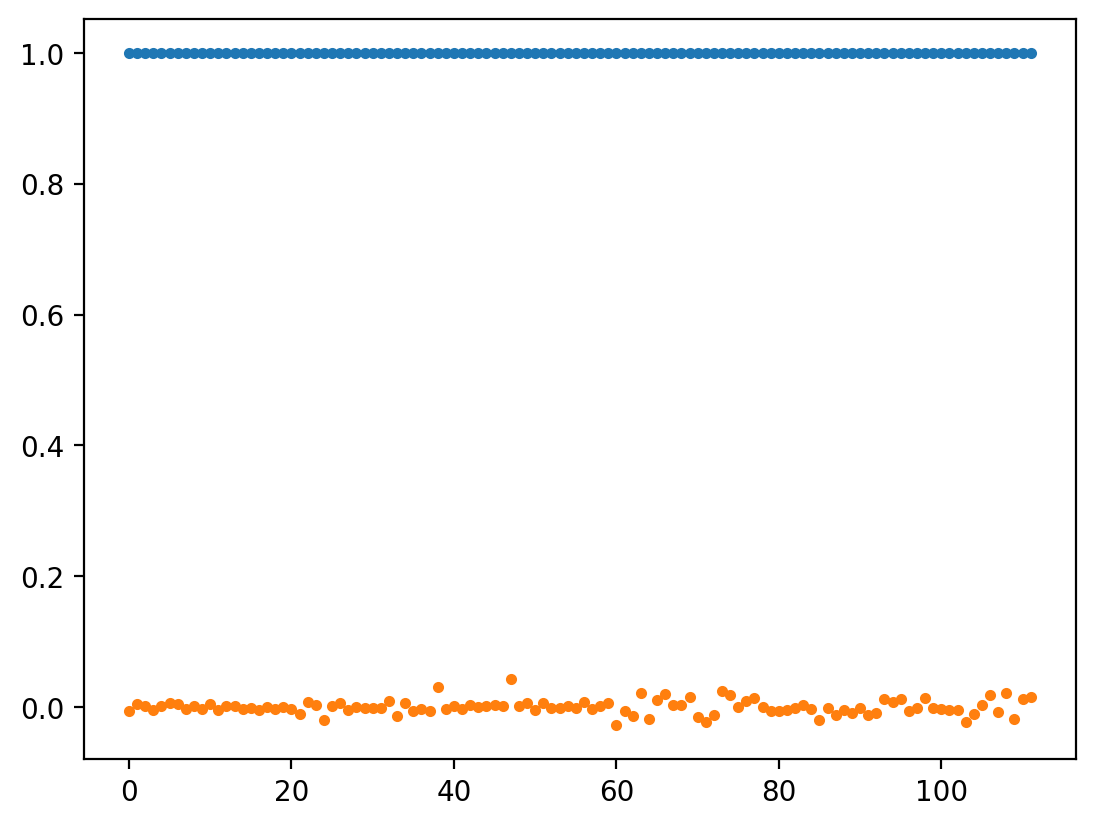

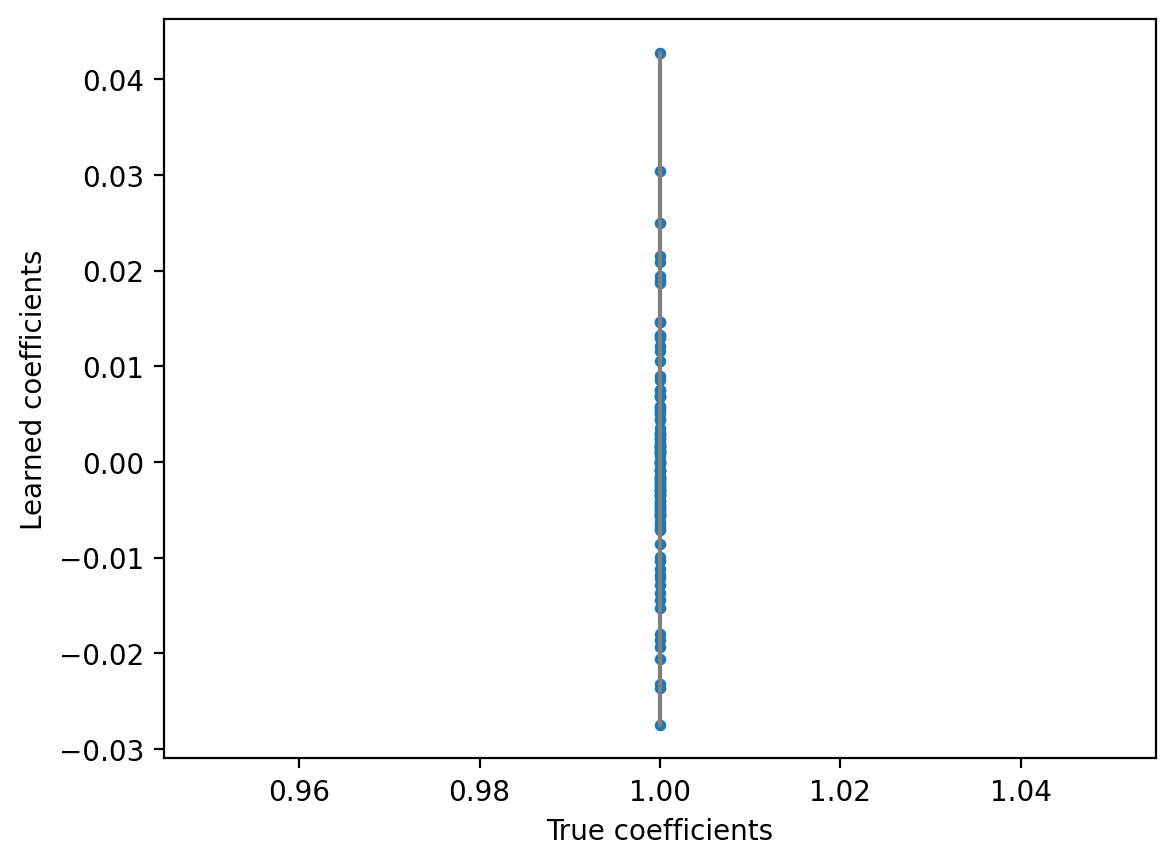

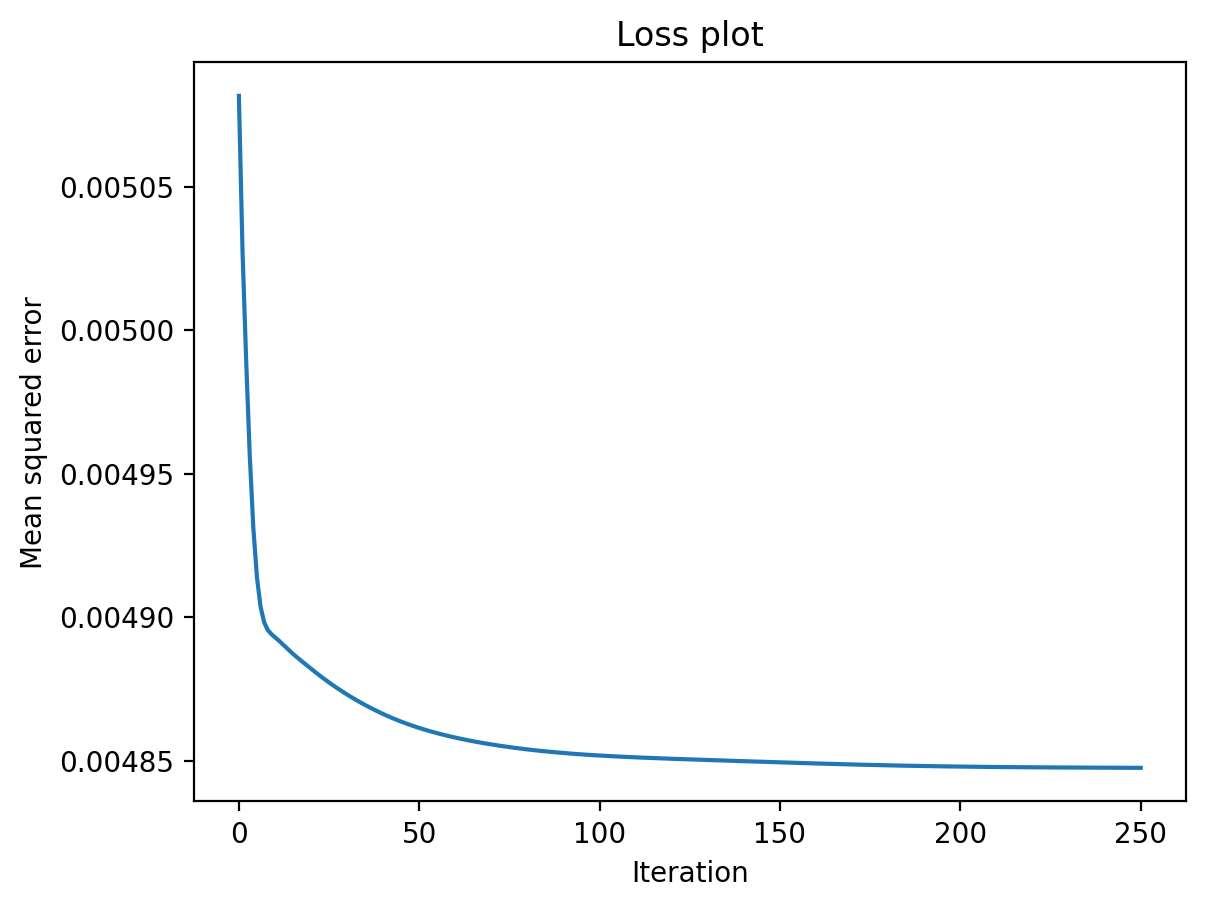

In [207]:
plt.figure()
plt.plot(w, ".", label="True weights")
plt.plot(w_hat, ".", label="Estimated weights")

plt.figure()
plt.plot([w.min(), w.max()], [w_hat.min(), w_hat.max()], "gray")
plt.scatter(w, w_hat, s=10)
plt.ylabel("Learned coefficients")
plt.xlabel("True coefficients")

plt.figure()
plt.plot(gl.losses_)
plt.title("Loss plot")
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")

print("X shape: {X.shape}".format(X=X))
print("True intercept: {intercept}".format(intercept=intercept))
print("Estimated intercept: {intercept}".format(intercept=gl.intercept_))
plt.show()